# Interprétabilité du modèle final XGBOOST

Suite au tests de la partie 2, nous avons sélectionné un modèle XGBOOST pour notre logiciel dde scoring de crédits.

## 1. Chargement des librairies

In [1]:
import sys
sys.path.insert(0, "../custom_functions")
from model_analysis import plot_confusion_matrix, plot_roc_curve

In [2]:
# Librairies Data Science
import pandas as pd
import numpy as np
from collections import Counter
import time
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle

In [3]:
from lime import lime_tabular
import shap

In [4]:
# Scikit-Learn
from sklearn.model_selection import (cross_val_score,
                                     RepeatedStratifiedKFold,
                                     cross_validate,
                                     StratifiedKFold)
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import (f1_score, recall_score,
                             roc_auc_score, precision_score,
                             r2_score, accuracy_score)
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline as skpipe

In [5]:
# Imbalanced-Learn
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

## 2. Chargement du dataset

Nous chargeons directement les train set et le test sets nettoyés et retraités par égalisation des classes par undersampling (voir notebook n°6)

In [6]:
# Chargement des données intégrales imputées + undersampling
# X = pd.read_csv('../data_models/X_top10_imputed.csv', index_col=0)
X_train = pd.read_csv('../data_models/X_train_imputed.csv', index_col=0)
X_test = pd.read_csv('../data_models/X_test_imputed.csv', index_col=0)

In [7]:
X_test.shape

(14354, 12)

In [8]:
X_train.head()

EXT_SOURCE_3  EXT_SOURCE_2  PREV_DAYS_DECISION_MIN  CODE_GENDER  \
0      0.547810      0.464989                  2467.0          1.0   
1      0.684828      0.284672                   617.0          0.0   
2      0.340906      0.682258                  1307.0          1.0   
3      0.778904      0.750705                  2823.0          0.0   
4      0.713631      0.419807                   422.0          1.0   

   DAYS_EMPLOYED  PREV_APP_CREDIT_PERC_MIN  INSTAL_DPD_MAX  AMT_CREDIT  \
0         1161.0                  1.026477            25.0    700830.0   
1         6830.0                  1.000000             0.0   1042560.0   
2         1045.0                  0.834716             6.0    112500.0   
3         8100.0                  0.000000            80.0    808650.0   
4          751.0                  0.825616             0.0    509602.5   

   DAYS_BIRTH  FLAG_OWN_CAR  NAME_EDUCATION_TYPE_Higher_education  TARGET  
0     15920.0           0.0                                   0.0     0.0  
1     14970.0           1.0                                   1.0     0.0  
2     10975.0           0.0                                   1.0     0.0  
3     14948.0           1.0                                   0.0     0.0  
4     11680.0           0.0                                   0.0     0.0

In [9]:
# Création de la target
y_train = X_train.TARGET
y_test = X_test.TARGET
# Supprimer la target des features
X_train = X_train.drop(columns='TARGET')
X_test = X_test.drop(columns='TARGET')

In [10]:
# Test égalité des classes
Counter(y_train)

Counter({0.0: 16792, 1.0: 16700})

In [11]:
Counter(y_test)

Counter({0.0: 7131, 1.0: 7223})

On voit qu'effectivement les classes sont bien équilibrées.

### Analyse de la corrélation entre les variables

Afin de nous échauffer, commençons par analyser les corrélations entre les variables (Pearson).

In [67]:
corr = X_test.iloc[:,:15].corr()

<AxesSubplot:>

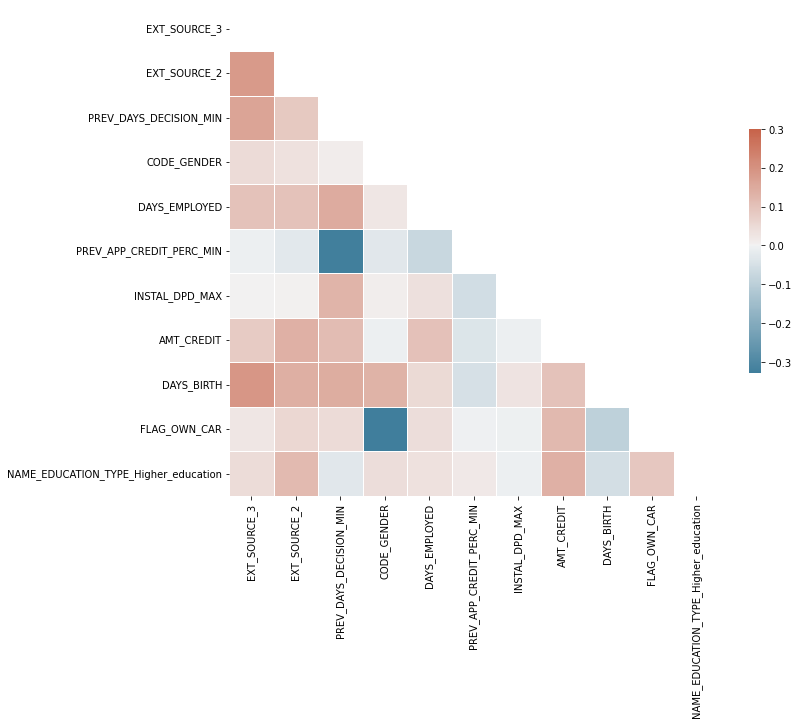

In [68]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## 3. Explicabilité: coefficients XGBoost

La première étape est de mieux comprendre comment fonctionne le modèle XGBoost retenu. Pour celà, on peut analyser l'importance de chaque feature dans le modèle avec la fonction 'feature_importances_' de scikit learn.

In [12]:
# Chargement du modèle final sélectionné à la fin du notebook n°9
file = open("../data_models/classifier_xgb_best.pkl",'rb')
xgbclassifier = pickle.load(file)
file.close()

In [13]:
xgbclassifier

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
              random_state=27, reg_alpha=0, ...)

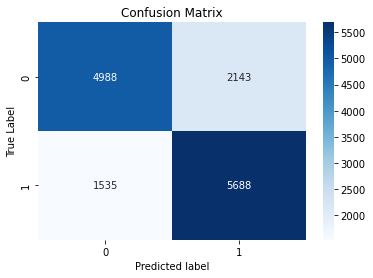

              precision    recall  f1-score   support

         0.0       0.76      0.70      0.73      7131
         1.0       0.73      0.79      0.76      7223

    accuracy                           0.74     14354
   macro avg       0.75      0.74      0.74     14354
weighted avg       0.75      0.74      0.74     14354

ROC AUC Score: 0.74


In [14]:
# prédiction des classes à l'aide du modèle
y_pred = xgbclassifier.predict(X_test)
# création de la matrice de confusion
plot_confusion_matrix(y_test, y_pred)

In [15]:
# Affichage du array contenant les coeeficients
xgbclassifier.feature_importances_

array([0.4119626 , 0.073867  , 0.02128001, 0.05684616, 0.17654893,
       0.02202782, 0.02835511, 0.02031431, 0.01816564, 0.04045449,
       0.13017793], dtype=float32)

In [16]:
# Extraction des coefficients xgboost
xgboost_coeff = xgbclassifier.feature_importances_

In [17]:
# Tri par ordre décroissant en valeur absolue
# On ne conserve ici que les indices
idx = np.argsort(np.abs(xgboost_coeff))[::-1] 

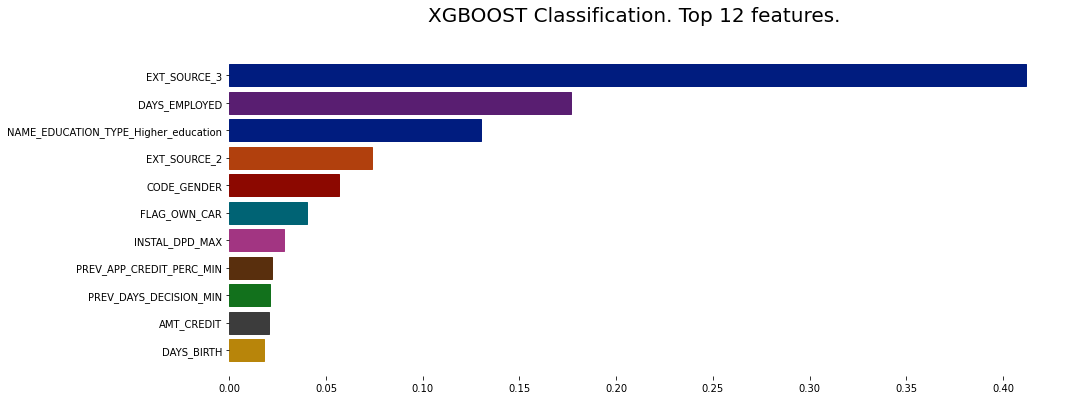

In [18]:
# Graphique des 10 coefficients les plus importants
plt.figure(figsize=(15,6))
top_x = 12
color_list =  sns.color_palette("dark", len(X_train.columns)) 
lreg_ax = plt.barh(X_train.columns[idx[:top_x]][::-1],
                   xgboost_coeff[idx[:top_x]][::-1])
for i,bar in enumerate(lreg_ax):
  bar.set_color(color_list[idx[:top_x][::-1][i]])
  plt.box(False) 
lr_title = plt.suptitle("XGBOOST Classification. Top " + 
                        str(top_x) + " features.", fontsize=20, fontweight="normal")

On voit que EXT_SOURCE_3 est la variable la plus importante du modèle, suivi de DAYS_EMPLOYED etc...

## 4. Explicabilité locale avec Lime

convert pandas to numpy: https://stackoverflow.com/questions/57717423/lime-feature-explaining-produces-invalid-key-error

https://coderzcolumn.com/tutorials/machine-learning/how-to-use-lime-to-understand-sklearn-models-predictions

In [19]:
# Nom des labels
target_names=['crédit accordé', 'crédit refusé']

In [20]:
# Création d'un objet LimeTabularExplainer sur le train set
lime_explainer = lime_tabular.LimeTabularExplainer(
    X_train,
    mode="classification",
    class_names=target_names,
    feature_names=X_train.columns,
    discretize_continuous=False  ## added to avoid bugs
    )

### Tirage au hasard d'un crédit correctement prévu

In [21]:
# prédiction sur le test set
preds = xgbclassifier.predict(X_test)
# Identification de l'index des prédictions correctes
correct_preds = np.argwhere((preds == y_test.values)).flatten()
# Choix d'un index au hasard parmi ces prédictions correctes
idx  = random.choice(correct_preds)
idx

5633

In [22]:
# 1ere façon d'isoler la ligne concernée avec Pandas
X_test.iloc[idx, :].values

array([4.50747282e-01, 6.70527706e-01, 4.60000000e+02, 0.00000000e+00,
       3.10000000e+02, 8.95672547e-01, 0.00000000e+00, 1.35000000e+05,
       1.89230000e+04, 1.00000000e+00, 0.00000000e+00])

In [24]:
# Même résultat mais avec numpy (plus court donc privilégié)
X_test.values[idx]

array([4.50747282e-01, 6.70527706e-01, 4.60000000e+02, 0.00000000e+00,
       3.10000000e+02, 8.95672547e-01, 0.00000000e+00, 1.35000000e+05,
       1.89230000e+04, 1.00000000e+00, 0.00000000e+00])

In [25]:
# Numéro de lasse prédite sur la ligne concernée avec le modèle
xgbclassifier.predict(X_test.values[idx].reshape(1,-1))[0]

0

### Utilisation de Lime pour expliquer les résultats sur ce crédit

In [27]:
# Affichage du score prévu & réel. Normalement c'est le même résultat...
print("Prediction : ", target_names[int(xgbclassifier.predict(X_test.values[idx].reshape(1,-1))[0])])
print("Actual :     ", target_names[int(y_test.values[idx])])

# Graphique analysant l'impact de chaque feature sur le résultat final. 
explanation = lime_explainer.explain_instance(X_test.values[idx],
                                         xgbclassifier.predict_proba,
                                         num_features=len(X_train.columns),
                                        )

explanation.show_in_notebook()

Prediction :  crédit accordé
Actual :      crédit accordé


Les variables en bleu contribuent positivement à la classe 0 (augmmenternt de crédit accordé).  
A l'inverse, les variables en orange contribuent négativement à la classe 0. Elles augmentent le risque d'avoir un crédit refusé.

### Tirage au hasard d'un crédit dont le résultat est erroné

In [28]:
# Identification de l'index des prédictions erronnées
false_preds = np.argwhere((preds != y_test.values)).flatten()
# Choix au hasard d'un index parmi les prévisions erronnées
idx  = random.choice(false_preds)
idx

5674

In [29]:
# Affichage du score prédit et du score réal
print("Prediction : ", target_names[int(xgbclassifier.predict(X_test.values[idx].reshape(1,-1))[0])])
print("Actual :     ", target_names[int(y_test.values[idx])])
# Graphique analysant l'impact de chaque feature sur le résultat final.
explanation = lime_explainer.explain_instance(X_test.values[idx],
                                         xgbclassifier.predict_proba,
                                         num_features=len(X_train.columns),)

explanation.show_in_notebook()

Prediction :  crédit refusé
Actual :      crédit accordé


## 5. Explicabilité avec Shap

In [30]:
# Utilisation de javascript
shap.initjs()

### Imputation & standardisation

Rappel: les données utilisées sont déjà imputées. Le modèle XGBoost a été entraîné sans standardisation donc on peut également ignorer cette étape.

### 5.1. Explicabilité locale avec force_plot

Trois possibilités pour calculer les valeurs de Shapley du crédit étudié:  
1) Utiliser l'intégralité du train set (plus long mais plus représentatif)  
2) Pour une utilisation dans un dashboard, sauvegarder les données calculées en 1 dans un fichier pickle  
3) Utiliser un échantillon. Vu que nous sommes ici dans en mode de test dans un notebook, nous privilégions la première méthode.

In [31]:
# création de l'explainer
xgb_explainer = shap.TreeExplainer(xgbclassifier, X_train)

#### Méthode 1: valeurs de Shapley sur intégralité du test set

In [32]:
%%time
# Attention l'éxécution de cette cellule prend du temps (environ 1 minute)
shap_values_X_test = xgb_explainer.shap_values(X_test)

 98%|===================| 14111/14354 [00:46<00:00]        

CPU times: user 46.4 s, sys: 55.7 ms, total: 46.5 s
Wall time: 46.3 s


On voit que cette opération est assez longue (près de 1 minute sur mon PC). Cette méthode n'est donc pas requise pour l'interprétabilité locale. Néanmoins elle reste requise pour calculer l'interprétabilité globale.

#### Méthode 2: sauvegarde pickle

Afin de résoudre ce problème et diminuer les temps de calcul, surtout pour l'interface front end de type streamlit comme celle utilisée dans la phase 5 du projet, il est possible de sauvegarder les valeurs de Shapley du test set dans un fichier pickle. Ainsi, il faut juste calculer les valeurs de Shapley du test set une seule fois dans ce notebook et les appeler au sein du dashboard, ce qui est très rapide si les données sont sauvegardées au format pickle.

In [33]:
# On peut aussi créer un fichier Pandas comprenant les noms de colonnes
shap_values_X_test_df = pd.DataFrame(shap_values_X_test, columns=X_test.columns)
shap_values_X_test_df.head()

EXT_SOURCE_3  EXT_SOURCE_2  PREV_DAYS_DECISION_MIN  CODE_GENDER  \
0     -0.123636     -0.515422               -0.367829    -0.156796   
1      0.060469      0.111792                0.024511    -0.138721   
2      0.030202      0.141142               -0.113882    -0.121662   
3      0.988708      0.053945               -0.248301    -0.151637   
4      0.033487      0.060189                0.304766    -0.138984   

   DAYS_EMPLOYED  PREV_APP_CREDIT_PERC_MIN  INSTAL_DPD_MAX  AMT_CREDIT  \
0      -0.121343                 -0.009156       -0.103451    0.005038   
1       0.052503                 -0.018676       -0.202394    0.208610   
2       0.196386                 -0.151568        0.289374   -0.311233   
3      -0.038793                 -0.068836        0.418669   -0.102423   
4      -0.013636                 -0.218748       -0.219130    0.173113   

   DAYS_BIRTH  FLAG_OWN_CAR  NAME_EDUCATION_TYPE_Higher_education  
0   -0.505992      0.063275                              0.064769  
1    0.104465     -0.220897                              0.078803  
2    0.236765      0.078522                              0.074375  
3   -0.411886      0.029965                              0.069263  
4    0.149732      0.091899                              0.080895

In [34]:
# création du fichier Pickle
pickle_out = open("../data_models/shap_values_test_set.pkl", "wb")
pickle.dump(shap_values_X_test, pickle_out)
pickle_out.close()

In [35]:
# We can also save Shapley values as a csv file
shap_values_X_test_df.to_csv("../data_models/shap_values_test_set.csv")

In [37]:
shap_values_X_test_df.shape

(14354, 11)

In [38]:
# how data look like... Default is an array
shap_values_X_test

array([[-0.12363592, -0.51542169, -0.36782898, ..., -0.50599196,
         0.06327513,  0.06476861],
       [ 0.06046919,  0.11179245,  0.02451089, ...,  0.10446509,
        -0.22089684,  0.07880259],
       [ 0.03020231,  0.14114151, -0.11388194, ...,  0.2367647 ,
         0.07852221,  0.07437487],
       ...,
       [-0.35526815, -0.71945477, -0.01791326, ..., -0.00452761,
         0.06933119, -0.25478787],
       [-0.10504925, -0.2347035 ,  0.53774047, ..., -0.06172377,
        -0.15254555,  0.058617  ],
       [-0.49925415, -0.0638445 ,  0.09733124, ..., -0.03686228,
         0.08993975,  0.07824644]])

Une fois que nous avons calculé les valeurs de Shapley sur l'ensemble des données du test set, il suffit juste d'extraire une ligne pour interpréter un crédit unique.

In [45]:
# Choix d'une ligne au hasard parmi les valeurs de Shapley du test set
sample_idx = random.randint(0, len(shap_values_X_test))
sample_idx

11618

In [46]:
len(shap_values_X_test)

14354

In [47]:
shap_values = shap_values_X_test[sample_idx]
shap_values

array([-0.05231306,  0.32190289, -0.52060071, -0.15833736,  4.71077733,
        0.25539538,  0.38577702,  0.08598328, -0.08566123,  0.03742664,
        0.04978171])

In [44]:
# Calculer la somme des valeurs de Shapley
print(shap_values.sum())
# Affichée la classe réelle
print("Classe réelle: ", int(y_test.iloc[sample_idx]))
# Calculer la classe prédite avec le modèle
prediction = xgbclassifier.predict(X_test.iloc[sample_idx,:].values.reshape(1, -1))[0]
print("Classe prédite: ", prediction)
# Afficher le graphe de force
shap.force_plot(xgb_explainer.expected_value, 
                shap_values, X_test.iloc[sample_idx,:])

-0.7056982848963527
Classe réelle:  0
Classe prédite:  0


Les variables en bleu à droite ont une contribution positive à la classe 0 (crédit accepté). Leur importance est proportionnelle à la surface su rectangle. A l'inverse, les variables en rouge contribuent positivement à la classe 1 (crédit refusé).

#### Méthode 3: sélection d'un échantillon de données du test set

Pour faire de l'analyse locale de manière plus rapide, on peut aussi extraire un échantillon du test set. Afin d'accélérer le calcul des coefficients de Shapley il est en effet recommandé de faire de l'échantillonage.

In [48]:
# use 600 samples of train data as background data
sub_sampled_train_data = shap.sample(X_train, 600, random_state=0)

In [49]:
# Taille de l'échantillon
sub_sampled_train_data.shape

(600, 11)

In [50]:
sub_sampled_train_data.head()

EXT_SOURCE_3  EXT_SOURCE_2  PREV_DAYS_DECISION_MIN  CODE_GENDER  \
2732       0.646330      0.688403                  2597.0          0.0   
21243      0.000527      0.661657                   654.0          1.0   
30403      0.746300      0.632622                  2504.0          1.0   
32103      0.497469      0.178064                  2423.0          1.0   
20757      0.526295      0.699994                  2386.0          1.0   

       DAYS_EMPLOYED  PREV_APP_CREDIT_PERC_MIN  INSTAL_DPD_MAX  AMT_CREDIT  \
2732          2726.0                  1.000000             0.0   1350000.0   
21243         2410.0                  1.000000             5.0    904500.0   
30403         2026.0                  0.909948            17.0   1024740.0   
32103          234.0                  0.000000            11.0    609183.0   
20757         1346.0                  0.923779            17.0     91692.0   

       DAYS_BIRTH  FLAG_OWN_CAR  NAME_EDUCATION_TYPE_Higher_education  
2732      20953.0           0.0                                   1.0  
21243     14848.0           0.0                                   0.0  
30403     10677.0           1.0                                   0.0  
32103     20622.0           0.0                                   0.0  
20757      9323.0           0.0                                   0.0

In [51]:
# création de l'objet TreeExplainer (requis pour les méthodes d'arbres)
explainer = shap.TreeExplainer(xgbclassifier, sub_sampled_train_data)

In [52]:
# Sélection aléatoire d'un crédit du test set
sample_idx = random.randint(0, len(X_test))
sub_sampled_test_data = X_test.values[sample_idx].reshape(1, -1)
sample_idx

11919

In [53]:
%%time
# Calcul des valeurs de Shapley sur l'échantillon aléatoire du test set
shap_values_sample = explainer.shap_values(sub_sampled_test_data)

CPU times: user 4.29 ms, sys: 39 µs, total: 4.33 ms
Wall time: 4.24 ms


On voit qu'ici le temps de calcul est très rapide, moins d'une seconde, contre près d'une minute sur tout le test set.

In [54]:
# Analyse de l'échantillon des valeurs de Shapley
shap_values_sample

array([[ 3.82281909e+00,  4.99918670e-01,  1.17285589e-01,
        -1.16406009e-01,  4.52029020e+00,  4.43912462e-02,
         9.20202243e-02,  3.11744568e-03, -2.14120984e-01,
         7.40292236e-02,  4.17478620e-02]])

https://colab.research.google.com/github/Jeffresh/datathon-2-dphi/blob/main/XAI_Assignment.ipynb#scrollTo=DiFAhyZVbWgf

To avoid error "UserWarning: X does not have valid feature names", use X_train_std.values instead of X_train_std which is a dataframe. See https://stackoverflow.com/questions/69326639/sklearn-warning-valid-feature-names-in-version-1-0

https://www.kaggle.com/code/kritidoneria/responsible-ai-model-explainability/notebook

In [55]:
print('Expected Value:', xgb_explainer.expected_value)
# création d'un dataframe avec les valeurs de Shapley
pd.DataFrame(shap_values_sample, columns=X_train.columns).head()                                  

Expected Value: -0.238319378055902


EXT_SOURCE_3  EXT_SOURCE_2  PREV_DAYS_DECISION_MIN  CODE_GENDER  \
0      3.822819      0.499919                0.117286    -0.116406   

   DAYS_EMPLOYED  PREV_APP_CREDIT_PERC_MIN  INSTAL_DPD_MAX  AMT_CREDIT  \
0        4.52029                  0.044391         0.09202    0.003117   

   DAYS_BIRTH  FLAG_OWN_CAR  NAME_EDUCATION_TYPE_Higher_education  
0   -0.214121      0.074029                              0.041748

Explication du fonctionnement de la fonction: https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195 et https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d
    

In [57]:
# Calculer la somme des valeurs de Shapley
print("Somme des valeurs de Shapley: ", shap_values_sample.sum())
# Affichée la classe réelle
print("Classe réelle: ", int(y_test.values[sample_idx]))
# Calculer la classe prédite avec le modèle
prediction = xgbclassifier.predict(X_test.values[sample_idx,:].reshape(1, -1))[0]
print("Classe prédite: ", prediction)
# Afficher le graphe de force
shap.force_plot(xgb_explainer.expected_value, 
                shap_values_sample, X_test.iloc[sample_idx,:])

Somme des valeurs de Shapley:  8.885092557616446
Classe réelle:  1
Classe prédite:  1


En rouge = influence négative sur le score (fait monter le risque de défaut). En bleu, impact positif (baisse du risque de défaut).

In [58]:
# Base value
explainer.expected_value

0.06339899709814802

### Graphe force_plot avec plusieurs observations (crédits)

Il est possible de faire un graphique pour voir l'influence des  variables sur plusieurs lignes de crédits. Ici on regarde l'impact de chaque variable sur les 10 premiers crédits du test set.

In [59]:
shap.force_plot(xgb_explainer.expected_value,
                xgb_explainer.shap_values(X_test.iloc[0:10, :]),
                feature_names=X_test.columns,
                out_names="credit score", figsize=(25,3),
                link="identity")

### Graphique bar plot

Un bar plot permet d'afficher le même type d'information mais sous une forme différente, peut être plus simple à comprendre.

In [60]:
X_test.shape

(14354, 11)

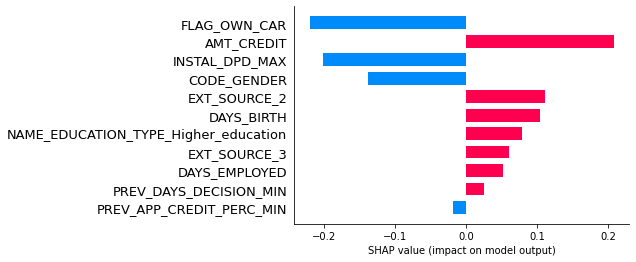

In [61]:
# Avec les 50 variables
shap.bar_plot(xgb_explainer.shap_values(X_test.values[1]),
              feature_names=X_test.columns,
              max_display=len(X_test.columns))

### Graphique Waterfall plot

Autre variante d'affichage des coefficients de Shapley

In [62]:
xgb_explainer.expected_value

-0.238319378055902

In [63]:
shap_values_sample

array([[ 3.82281909e+00,  4.99918670e-01,  1.17285589e-01,
        -1.16406009e-01,  4.52029020e+00,  4.43912462e-02,
         9.20202243e-02,  3.11744568e-03, -2.14120984e-01,
         7.40292236e-02,  4.17478620e-02]])

In [65]:
%%time
# création de l'object xgb_explainer requis pour ce graphique
shap_obj = xgb_explainer(X_test)

100%|===================| 14321/14354 [00:47<00:00]        

CPU times: user 47 s, sys: 98.1 ms, total: 47.1 s
Wall time: 46.9 s


In [340]:
# On peut regarder à quoi ressemble cet objet. Ici exemple sur le 1er crédit.
shap_obj[0]

.values =
array([-0.65499843, -0.54291718, -0.15282361, -0.20590741, -0.4637733 ,
        0.07058874, -0.15111896,  0.11977465, -0.7662702 ,  0.07290721,
        0.13229744])

.base_values =
0.5541492510066331

.data =
array([5.20897599e-01, 6.81290598e-01, 2.72800000e+03, 1.00000000e+00,
       1.47000000e+02, 8.78271562e-01, 0.00000000e+00, 3.60000000e+05,
       2.14380000e+04, 0.00000000e+00, 0.00000000e+00])

In [40]:
# sauvegarde du fichier en format Pickle (utilisé dans le dashboard)
pickle_out = open("../data_models/shap_obj.pkl", "wb")
pickle.dump(shap_obj, pickle_out)
pickle_out.close()

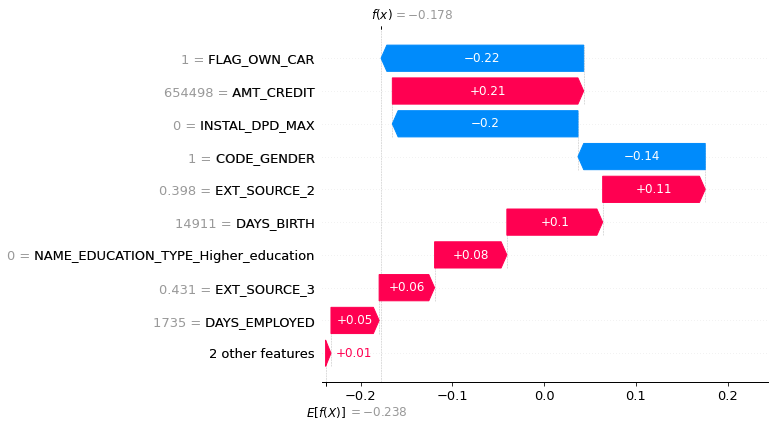

In [66]:
# Affichage du graphique sur le 2eme crédit du test set
shap.waterfall_plot(shap_obj[1])

Analyse du graphique ci-dessus:  
- impact positif d'un véhicule personnel (avoir une voiture augmente la probabilité d'acceptation du crédit)  
- impact négatif du montant du crédit précédent (plus le montant est gros, plus il y a de risque de refus du crédit)
- impact positif du genre (homme) sur la probabilité d'acceptation du crédit. 
- etc...

### 5.2. Explicabilité globale des variables

On reprend les valeurs de Shapley calculées plus haut sur l'intégralité du test set (shap_values_X_test)

#### Graphique Summary plot

In [316]:
class_names=['accepté','refusé']

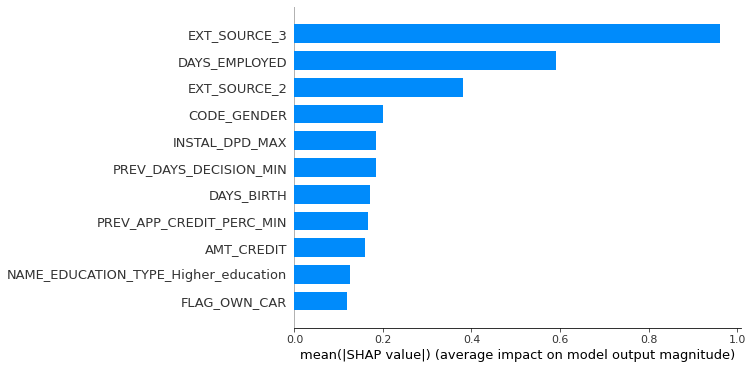

In [322]:
shap.summary_plot(shap_values_X_test, X_test.values, plot_type="bar",
                  class_names= class_names,
                  feature_names = X_test.columns)

Ce graphique permet de voir quelles sont les variables ayant le plus d'influence dans le modèle (plus grandes valeurs de Shapley en valkeur absolue). Les variables sont classées par ordre décroissant d'importance.

#### Graphique Beeswarm

https://github.com/slundberg/shap/issues/1460

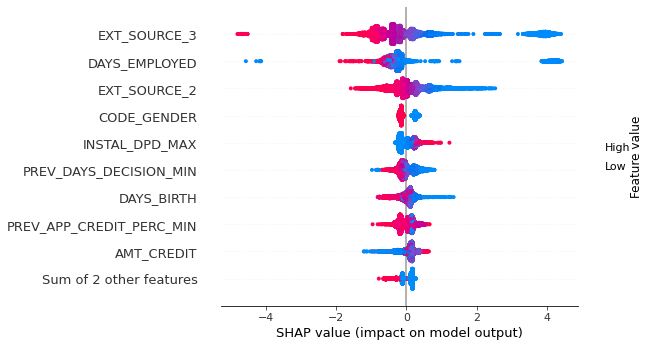

In [328]:
shap.plots.beeswarm(shap_obj)

La couleur rouge signifie un niveau élevé alors que le bleu signifie un niveau faible. L'axe des X indique si l'impact et positif sur les valeurs de Shapley (à doite) ou négatif (à gauche).  
Ex: Les valeurs de la variable EXT_SOURCE_3 sont corrélées positivement avec les valeurs de Shapley. Plus leur niveau est élevé (rouge), moins il y a de risque de voir le crédit refusé (valeur de Shapley négatives). A l'inverse, plus le niveau est bas (bleu), plus le risque d'avoir un refus de crédit augmente (valeur de Shapley positive).

#### Graphique Dependence plot - Global Interpretability

Ces graphiques illustrent la relation entre le niveau d'une variable et niveau de la valeur de Shapley. A droite, la variable la plus corrélée est mentionnée. La couleur des points permet de repérer le type de relation entre les deux variables les plus corrélées (corrélation positive ou négative).

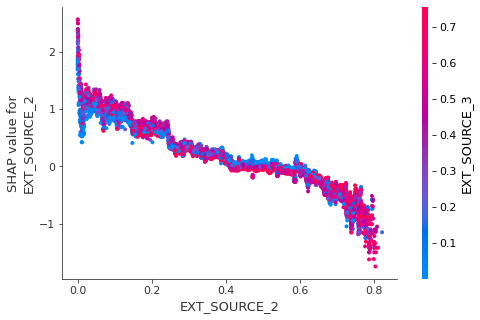

In [71]:
shap.dependence_plot("EXT_SOURCE_2", shap_values_X_test, X_test)

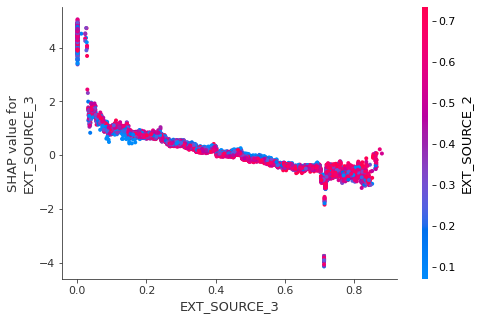

In [72]:
shap.dependence_plot("EXT_SOURCE_3", shap_values_X_test, X_test)

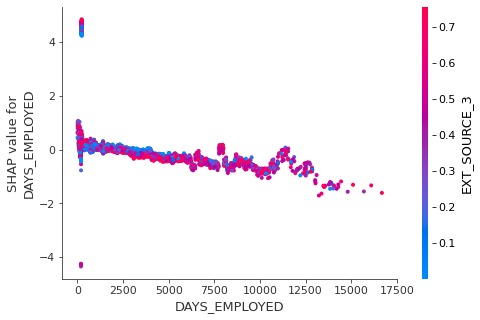

In [73]:
shap.dependence_plot("DAYS_EMPLOYED", shap_values_X_test, X_test)